In [ ]:
import gc
gc.collect()

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [23]:
import numpy as np
import skimage.measure
# import pydicom
import vtk
from vtk.util import numpy_support
import os
import matplotlib.pyplot as plt
import cv2

In [24]:
plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

<Figure size 432x288 with 0 Axes>

In [51]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)
        
val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [53]:
# only 0 and 255 in seg
subfolder1 = "_0255/"
# subfolder1 = "/"
subfolder2 = "_re255fill/"

path1 = "02_data/train_image"+subfolder1
path2 = "02_data/train_mask"+subfolder2
path3 = "02_data/val_image"+subfolder1
path4 = "02_data/val_mask"+subfolder2

# # scale to 255 in val
# path1 = "02_data/train_image_re255/"
# path2 = "02_data/train_mask_re255/"
# path3 = "02_data/val_image_re255/"
# path4 = "02_data/val_mask_re255/"

batch_size1 = 16

train_image_generator = train_datagen.flow_from_directory(
    path1,
    color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

train_mask_generator = train_datagen.flow_from_directory(
    path2,
    color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

val_image_generator = val_datagen.flow_from_directory(
    path3,
    color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)


val_mask_generator = val_datagen.flow_from_directory(
    path4,
    color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

Found 472 images belonging to 1 classes.
Found 472 images belonging to 1 classes.
Found 203 images belonging to 1 classes.
Found 203 images belonging to 1 classes.


In [54]:
def my_image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask)
        
train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

In [55]:
smooth = 1.
# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)


In [56]:
# mutiple GPU (less auc?)

from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
import tensorflow as tf

num_gpus = 2
def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    cross_tower_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=num_gpus)
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_tower_ops)
#     strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        inputs = keras.Input((sample_width, sample_height, 1))
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(inputs)
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv1)
        conv1 = tf.reshape(conv1, tf.shape(conv1))
        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        drop1 = keras.layers.Dropout(0.5)(pool1)

        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(drop1)
        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv2)
        conv2 = tf.reshape(conv2, tf.shape(conv2))
        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        drop2 = keras.layers.Dropout(0.5)(pool2)

        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(drop2)
        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv3)
        conv3 = tf.reshape(conv3, tf.shape(conv3))
        pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        drop3 = keras.layers.Dropout(0.3)(pool3)

        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(drop3)
        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv4)
        conv4 = tf.reshape(conv4, tf.shape(conv4))
        pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        drop4 = keras.layers.Dropout(0.3)(pool4)

        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(drop4)
        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(conv5)
        conv5 = tf.reshape(conv5, tf.shape(conv5))
    
        conv5u = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv5)
        conv5u = tf.reshape(conv5u, tf.shape(conv5u))
        up6 = keras.layers.concatenate([conv5u, conv4], axis=3)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(up6)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv6)
        conv6 = tf.reshape(conv6, tf.shape(conv6))
    
        conv6u = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv6)
        conv6u = tf.reshape(conv6u, tf.shape(conv6u))
        up7 = keras.layers.concatenate([conv6u, conv3], axis=3)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(up7)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv7)
        conv7 = tf.reshape(conv7, tf.shape(conv7))
    
        conv7u = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv7)
        conv7u = tf.reshape(conv7u, tf.shape(conv7u))
        up8 = keras.layers.concatenate([conv7u, conv2], axis=3)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(up8)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv8)
        conv8 = tf.reshape(conv8, tf.shape(conv8))
    
        conv8u = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv8)
        conv8u = tf.reshape(conv8u, tf.shape(conv8u))
        up9 = keras.layers.concatenate([conv8u, conv1], axis=3)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(up9)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv9)
        conv9 = tf.reshape(conv9, tf.shape(conv9))

        conv10 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
        conv10 = tf.reshape(conv10, tf.shape(conv10))

        model = keras.Model(inputs=[inputs], outputs=[conv10])

        model.compile(optimizer=optimizer(lr=lr), loss=loss_metric, metrics=metrics)
        return model

In [ ]:
model.summary()

In [ ]:
# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# historyTF = model.fit(
#     train_generator, 
#     batch_size=4, 
#     epochs=10, 
#     validation_data = 
#     (val_image_generator,
#      val_mask_generator)
# )

In [ ]:
# fit the keras model on the dataset
# historyKe = model.fit(train_image_generator, train_mask_generator, epochs=150, batch_size=10)

# train_generator = zip(train_image_generator, train_mask_generator)
# val_generator = zip(val_image_generator, val_mask_generator)

# from keras import backend as K

# historyTF = model.fit(train_generator, epochs=10, validation_data=val_generator)


In [57]:
sample_width = 256
sample_height = 256

# tf.keras.optimizers.SGD
# tf.keras.optimizers.Adam

# dice_coef_loss
# tf.keras.losses.binary_crossentropy
# tf.keras.losses.BinaryCrossentropy()

model = get_model(optimizer=tf.keras.optimizers.Adam, loss_metric=dice_coef_loss, metrics=['AUC', dice_coef], lr=1e-6)
# 'AUC'

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [58]:
earlyStopImprove = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint('03_model/Model_seg3imagere_23.32.h5', monitor='auc', verbose=1, save_best_only=True, mode='max')

ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('auc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

NO_OF_EPOCHS = 50

NO_OF_TRAINING_IMAGES = len(os.listdir(path1+'image/'))
NO_OF_VAL_IMAGES = len(os.listdir(path3+'image/'))

# NO_OF_TRAINING_IMAGES = len(os.listdir('02_data/train_image_re255/image/'))
# NO_OF_VAL_IMAGES = len(os.listdir('02_data/val_image_re255/image/'))

BATCH_SIZE = batch_size1

results = model.fit(train_generator, 
                    epochs=NO_OF_EPOCHS, 
                    steps_per_epoch=(NO_OF_TRAINING_IMAGES//BATCH_SIZE), 
                    validation_data=val_generator, 
                    validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE),
                    callbacks=[checkpoint] # myCallback(), checkpoint, earlyStopImprove
                   )

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = hierarchical_copy, num_packs = 2
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = hierarchical_copy, num_packs = 2
29/29 [==============================] - ETA: 0s - loss: -2.5066e-04 - auc: 0.7596 - dice_coef: 2.5066e-04
Epoch 00001: auc improved from -inf to 0.75960, saving model to 03_model\Model_seg3imagere_23.32.h5
29/29 [==============================] - 12s 408ms/step - loss: -2.5066e-04 - auc: 0.7596 - dice_coef: 2.5066e-04 - val_loss: -0.0857 - val_auc: 0.7785 - val_dice_coef: 0.0857
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: -2.5402e-04 - auc: 0.7692 - dice_coef: 2.5400e-04
Epoch 00002: auc improved from 0.75960 to 0.76918, saving model to 03_model\Model_seg3imagere_23.32.h5
29/29 [==============================] - 11s 370ms/step - loss: -2.5402e-04 - auc: 0.7692 - dice_coef: 2.5400e-04 - val_loss: -0.0875 - val_auc: 0.8001 - val_dice_coef: 0.0880
Epoch 3/50


KeyboardInterrupt: 

In [59]:
# load for countinue trainning
model = tf.keras.models.load_model('03_model/Model_seg3imagere_23.32.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})

In [ ]:
# model.save('03_model/Model_ep200_23.32.h5')

In [ ]:
# !mkdir saved_model
# model.save('03_model/saved_model/my_model_ep100') 

In [42]:
# load model
load_model = tf.keras.models.load_model('03_model/Model_ep50.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef})

In [ ]:
# test loaded model
earlyStopImprove = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)

loss, acc = load_model.evaluate(val_generator, batch_size=batch_size1, verbose=2, callbacks=[earlyStopImprove]
                              )
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

In [ ]:
print(results.history.keys())

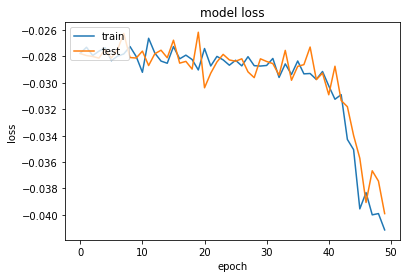

In [27]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

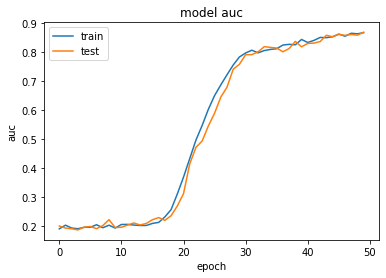

In [28]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [32]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
from PIL import Image

# img0 = Image.fromarray(val_image_generator[3].astype(np.uint8), mode = "L")

im = Image.new('L', (256, 256))
im.putdata(val_image_generator[5])
plt.imshow(im)

In [38]:
from copy import deepcopy

dataset_as_tuple = deepcopy(next(val_image_generator))

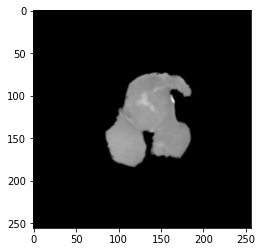

In [48]:
samples_to_predict = np.array(dataset_as_tuple[0])
samples_to_predict2 = (((samples_to_predict - samples_to_predict.min()) / (samples_to_predict.max() - samples_to_predict.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict2[0,:,:])

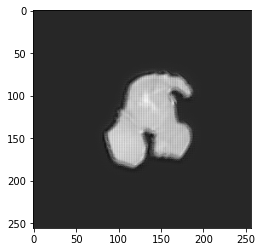

In [60]:
predictions = model.predict(dataset_as_tuple[0])
samples_to_predict3 = np.array(predictions[0])
# samples_to_predict4 = (((samples_to_predict3 - samples_to_predict3.min()) / (samples_to_predict3.max() - samples_to_predict3.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict3[:,:,0])

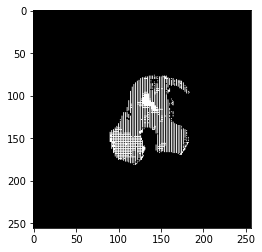

In [63]:
samples_to_predict5 = samples_to_predict3.copy()
samples_to_predict5[samples_to_predict5 >= np.percentile(samples_to_predict5, 95)] = 255
samples_to_predict5[samples_to_predict5 != 255 ] = 0
plt.imshow(samples_to_predict5[:,:,0])

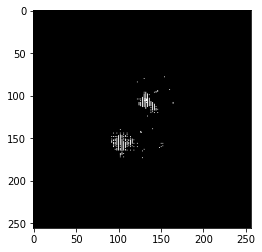

In [70]:
samples_to_predict5 = samples_to_predict3.copy()
samples_to_predict5[samples_to_predict5 <= np.percentile(samples_to_predict5, 99.5)] = 0
# samples_to_predict5[samples_to_predict5 != 255 ] = 0
plt.imshow(samples_to_predict5[:,:,0])

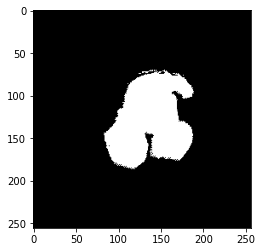

In [66]:
from skimage.filters import threshold_otsu, threshold_mean, threshold_minimum, threshold_local
thresh = threshold_mean(samples_to_predict3[:,:,0])
binary = samples_to_predict3[:,:,0] > thresh
# binary1 = samples_to_predict2[0,:,:] > samples_to_predict3
plt.imshow(binary)

In [ ]:
dataset_as_tuple = next(val_mask_generator)

samples_to_predict = np.array(dataset_as_tuple[0])
samples_to_predict2 = (((samples_to_predict - samples_to_predict.min()) / (samples_to_predict.max() - samples_to_predict.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict2[0,:,:])

In [ ]:
samples_to_predict4[150,:,0]

In [ ]:
a1 = np.array(dataset_as_tuple[0])[0,:,:]
plt.imshow(a1)

In [ ]:
print(a1.max(),a1.min())

# Test

In [ ]:
# test 1 

from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
import tensorflow as tf

num_gpus = 2
def get_model1(optimizer, loss_metric, metrics, lr=1e-3, n_filters = 32):
#     cross_tower_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=num_gpus)
#     strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_tower_ops)
# #     strategy = tf.distribute.MirroredStrategy()
#     with strategy.scope():
        inputs = keras.Input((sample_width, sample_height, 1))
        conv1 = keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu', padding='SAME')(inputs)
        conv1 = keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu', padding='SAME')(conv1)
        conv1 = tf.reshape(conv1, tf.shape(conv1))
        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        drop1 = keras.layers.Dropout(0.2)(pool1)

        conv2 = keras.layers.Conv2D(n_filters*4, (3, 3), activation='relu', padding='SAME')(drop1)
        conv2 = keras.layers.Conv2D(n_filters*4, (3, 3), activation='relu', padding='SAME')(conv2)
        conv2 = tf.reshape(conv2, tf.shape(conv2))
        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        drop2 = keras.layers.Dropout(0.2)(pool2)

        conv3 = keras.layers.Conv2D(n_filters*8, (3, 3), activation='relu', padding='SAME')(drop2)
        conv3 = keras.layers.Conv2D(n_filters*8, (3, 3), activation='relu', padding='SAME')(conv3)
        conv3 = tf.reshape(conv3, tf.shape(conv3))
        pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        drop3 = keras.layers.Dropout(0.3)(pool3)

        conv4 = keras.layers.Conv2D(n_filters*16, (3, 3), activation='relu', padding='SAME')(drop3)
        conv4 = keras.layers.Conv2D(n_filters*16, (3, 3), activation='relu', padding='SAME')(conv4)
        conv4 = tf.reshape(conv4, tf.shape(conv4))
        pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        drop4 = keras.layers.Dropout(0.3)(pool4)

        conv5 = keras.layers.Conv2D(n_filters*32, (3, 3), activation='relu', padding='SAME')(drop4)
        conv5 = keras.layers.Conv2D(n_filters*32, (3, 3), activation='relu', padding='SAME')(conv5)
        conv5 = tf.reshape(conv5, tf.shape(conv5))
    
        conv5u = tf.keras.layers.Conv2DTranspose(filters=n_filters*16, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv5)
        conv5u = tf.reshape(conv5u, tf.shape(conv5u))
        up6 = keras.layers.concatenate([conv5u, conv4], axis=3)
        up6 = keras.layers.Dropout(0.2)(up6)
        conv6 = keras.layers.Conv2D(n_filters*16, (3, 3), activation='relu', padding='SAME')(up6)
        conv6 = keras.layers.Conv2D(n_filters*16, (3, 3), activation='relu', padding='SAME')(conv6)
        conv6 = tf.reshape(conv6, tf.shape(conv6))
    
        conv6u = tf.keras.layers.Conv2DTranspose(filters=n_filters*8, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv6)
        conv6u = tf.reshape(conv6u, tf.shape(conv6u))
        up7 = keras.layers.concatenate([conv6u, conv3], axis=3)
        up7 = keras.layers.Dropout(0.2)(up7)
        conv7 = keras.layers.Conv2D(n_filters*8, (3, 3), activation='relu', padding='SAME')(up7)
        conv7 = keras.layers.Conv2D(n_filters*8, (3, 3), activation='relu', padding='SAME')(conv7)
        conv7 = tf.reshape(conv7, tf.shape(conv7))
    
        conv7u = tf.keras.layers.Conv2DTranspose(filters=n_filters*4, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv7)
        conv7u = tf.reshape(conv7u, tf.shape(conv7u))
        up8 = keras.layers.concatenate([conv7u, conv2], axis=3)
        up8 = keras.layers.Dropout(0.2)(up8)
        conv8 = keras.layers.Conv2D(n_filters*4, (3, 3), activation='relu', padding='SAME')(up8)
        conv8 = keras.layers.Conv2D(n_filters*4, (3, 3), activation='relu', padding='SAME')(conv8)
        conv8 = tf.reshape(conv8, tf.shape(conv8))
    
        conv8u = tf.keras.layers.Conv2DTranspose(filters=n_filters*2, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv8)
        conv8u = tf.reshape(conv8u, tf.shape(conv8u))
        up9 = keras.layers.concatenate([conv8u, conv1], axis=3)
        up9 = keras.layers.Dropout(0.2)(up9)
        conv9 = keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu', padding='SAME')(up9)
        conv9 = keras.layers.Conv2D(n_filters*2, (3, 3), activation='relu', padding='SAME')(conv9)
        conv9 = tf.reshape(conv9, tf.shape(conv9))

        conv10 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
        conv10 = tf.reshape(conv10, tf.shape(conv10))

        model = keras.Model(inputs=[inputs], outputs=[conv10])

        model.compile(optimizer=optimizer(lr=lr), loss=loss_metric, metrics=metrics)
        return model


In [ ]:
# test 2

from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
import tensorflow as tf

num_gpus = 2
def get_model1(optimizer, loss_metric, metrics, lr=1e-3):
    cross_tower_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=num_gpus)
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_tower_ops)
#     strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        inputs = keras.Input((sample_width, sample_height, 1))
    
        conv0 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME')(inputs)
        conv0 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME')(conv0)
        conv0 = tf.reshape(conv0, tf.shape(conv0))
        pool0 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv0)
        drop0 = keras.layers.Dropout(0.1)(pool0)
    
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(drop0)
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv1)
        conv1 = tf.reshape(conv1, tf.shape(conv1))
        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        drop1 = keras.layers.Dropout(0.1)(pool1)

        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(drop1)
        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv2)
        conv2 = tf.reshape(conv2, tf.shape(conv2))
        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        drop2 = keras.layers.Dropout(0.1)(pool2)

        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(drop2)
        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv3)
        conv3 = tf.reshape(conv3, tf.shape(conv3))
        pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        drop3 = keras.layers.Dropout(0.1)(pool3)

        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(drop3)
        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv4)
        conv4 = tf.reshape(conv4, tf.shape(conv4))
        pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        drop4 = keras.layers.Dropout(0.1)(pool4)
        
        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(drop4)
        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(conv5)
        conv5 = tf.reshape(conv5, tf.shape(conv5))
        pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)
        drop5 = keras.layers.Dropout(0.1)(pool5)

        convc5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='SAME')(drop5)
        convc5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='SAME')(convc5)
        convc5 = tf.reshape(convc5, tf.shape(convc5))
        
        convc5u = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(convc5)
        convc5u = tf.reshape(convc5u, tf.shape(convc5u))
        upc6 = keras.layers.concatenate([convc5u, conv5], axis=3)
        convc6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(upc6)
        convc6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(convc6)
        convc6 = tf.reshape(convc6, tf.shape(convc6))
    
        conv5u = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(convc6)
        conv5u = tf.reshape(conv5u, tf.shape(conv5u))
        up6 = keras.layers.concatenate([conv5u, conv4], axis=3)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(up6)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv6)
        conv6 = tf.reshape(conv6, tf.shape(conv6))
    
        conv6u = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv6)
        conv6u = tf.reshape(conv6u, tf.shape(conv6u))
        up7 = keras.layers.concatenate([conv6u, conv3], axis=3)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(up7)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv7)
        conv7 = tf.reshape(conv7, tf.shape(conv7))
    
        conv7u = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv7)
        conv7u = tf.reshape(conv7u, tf.shape(conv7u))
        up8 = keras.layers.concatenate([conv7u, conv2], axis=3)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(up8)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv8)
        conv8 = tf.reshape(conv8, tf.shape(conv8))
    
        conv8u = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv8)
        conv8u = tf.reshape(conv8u, tf.shape(conv8u))
        up9 = keras.layers.concatenate([conv8u, conv1], axis=3)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(up9)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv9)
        conv9 = tf.reshape(conv9, tf.shape(conv9))
    
        conv9u = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv9)
        conv9u = tf.reshape(conv9u, tf.shape(conv9u))
        up10 = keras.layers.concatenate([conv9u, conv0], axis=3)
        conv10 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME')(up10)
        conv10 = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='SAME')(conv10)
        conv10 = tf.reshape(conv10, tf.shape(conv10))

        conv11 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv10)
        conv11 = tf.reshape(conv11, tf.shape(conv11))

        model = keras.Model(inputs=[inputs], outputs=[conv11])

        model.compile(optimizer=optimizer(lr=lr), loss=loss_metric, metrics=metrics)
        return model



In [ ]:
sample_width = 256
sample_height = 256

# tf.keras.optimizers.SGD
# tf.keras.optimizers.Adam

# dice_coef_loss
# tf.keras.losses.binary_crossentropy
# tf.keras.losses.BinaryCrossentropy()

model = get_model1(optimizer=tf.keras.optimizers.Adam, loss_metric=dice_coef_loss, metrics=['AUC', dice_coef], lr=1e-6)
# 'AUC'




In [ ]:
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D
from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
import tensorflow as tf

def get_model2():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up3 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up3)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = keras.Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': [tf.keras.metrics.Accuracy()]
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model




In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

# tf.keras.optimizers.SGD
# tf.keras.optimizers.Adam

# dice_coef_loss
# tf.keras.losses.binary_crossentropy
# tf.keras.losses.BinaryCrossentropy()

model = get_model2()
# 'AUC'

In [ ]:
NO_OF_EPOCHS = 10

NO_OF_TRAINING_IMAGES = len(os.listdir(path1+'image/'))
NO_OF_VAL_IMAGES = len(os.listdir(path3+'image/'))

# NO_OF_TRAINING_IMAGES = len(os.listdir('02_data/train_image_re255/image/'))
# NO_OF_VAL_IMAGES = len(os.listdir('02_data/val_image_re255/image/'))

BATCH_SIZE = batch_size1

results = model.fit(train_generator, 
                    epochs=NO_OF_EPOCHS, 
                    steps_per_epoch=(NO_OF_TRAINING_IMAGES//BATCH_SIZE), 
                    validation_data=val_generator, 
                    validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE) #,
                    #callbacks=[checkpoint] # myCallback(), checkpoint, earlyStopImprove
                   )